# Some tests with Symmetric Cryptography

In [1]:
# Some imports
from os import urandom
from binascii import hexlify
import time
import collections
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# if you get an error about of missing package, uncomment the following line
#pip install cryptography #library provides only a few suggested APIs, but a lot of stuff in the imports

from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.exceptions import InvalidTag
# from cryptography.hazmat.backends import default_backend

In [3]:
# We use AES-128
# key size is 16 bytes
KEYLEN = 16

# block size is 16 bytes
BLOCKLEN = 16

## Example 1
We will encrypt a single block of data using AES in ECB mode

In [4]:
# set plaintext block p to the all-zero string
p = b'\x00'*BLOCKLEN

# print as hex string
print("p = {}".format(hexlify(p)))

p = b'00000000000000000000000000000000'


In [5]:
# pick a random key using Python's crypto PRNG
k = urandom(KEYLEN)

# print as hex string
print("k = {}".format(hexlify(k)))

k = b'9c2e8dcda294057515062903501b3c49'


In [6]:
# create an instance of AES-128 to encrypt a single block
cipher = Cipher(algorithms.AES(k), modes.ECB())# to implement the alg: name + mode

In [7]:
# encrypt plaintext p to ciphertext c
aes_encrypt = cipher.encryptor()

#funct starts an encr -> chunck->chunck->...(requires a lot of memory)
c = aes_encrypt.update(p) + aes_encrypt.finalize()#upfate encrypts another chunck
print ("E({},{}) = {}".format(hexlify(k),hexlify(p), hexlify(c)))#for AES output looks like random

E(b'9c2e8dcda294057515062903501b3c49',b'00000000000000000000000000000000') = b'd49aa1b17ca9c65dd6184d4a67b6d4d1'


In [8]:
# decrypt ciphertext c to plaintext p
aes_decrypt = cipher.decryptor()

p = aes_decrypt.update(c) + aes_decrypt.finalize()
print("D({},{}) = {}".format(hexlify(k),hexlify(c), hexlify(p)))

D(b'9c2e8dcda294057515062903501b3c49',b'd49aa1b17ca9c65dd6184d4a67b6d4d1') = b'00000000000000000000000000000000'


## Example 2
We encrypt two identical blocks with ECB and see that their encryption is the same

In [9]:
# a function that pretty prints the plaintext into blocks
def blocks(data):
    split = [hexlify(data[i:i+BLOCKLEN]) for i in range(0, len(data), BLOCKLEN)]
    return b' '.join(split)

In [10]:
# set plaintext block p to the all-zero string
#now the msg is 2 blocks(identical)
p = b'\x00'*BLOCKLEN*2
print("p = {}".format(blocks(p)))

p = b'00000000000000000000000000000000 00000000000000000000000000000000'


In [11]:
# pick a random key using Python's crypto PRNG
k = urandom(KEYLEN)
print("k = {}".format(hexlify(k)))

k = b'961b05a60a73a43f71d0ec7c8930a852'


In [12]:
# create an instance of AES-128 to encrypt and decrypt
cipher = Cipher(algorithms.AES(k), modes.ECB())

In [13]:
# encrypt plaintext p to ciphertext c
aes_encrypt = cipher.encryptor()
c = aes_encrypt.update(p) + aes_encrypt.finalize()
print("enc({}) =\n    {}".format(blocks(p), blocks(c)))#same cyphertext

enc(b'00000000000000000000000000000000 00000000000000000000000000000000') =
    b'd84484f8ff932aaf6e0a6a56f8cdf132 d84484f8ff932aaf6e0a6a56f8cdf132'


## Example 3
We encrypt the Linux mascot with ecb, and see that patterns get through. According to Marsh Ray,
> "ECB cannot be used because you can see the penguin"

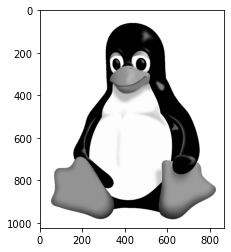

In [14]:
# Load the penguin image
# Uncomment the following line if you get an error of about a missing file
#!wget -q https://raw.githubusercontent.com/gverticale/network-security-and-cryptography/master/tux_gray.png

tux = plt.imread('tux_gray.png')
plt.imshow(tux)
plt.show()

In [15]:
# Keep only luminance and serialize the image
# The plaintext is a string of bytes
tux = tux[:,:,1] * 255
tux = tux.astype(np.uint8)
p = tux.tobytes()

In [16]:
# Generate a key and an instance of AES
k = urandom(KEYLEN)
cipher = Cipher(algorithms.AES(k), modes.ECB())

In [17]:
# Encrypt the image
aes_encrypt = cipher.encryptor()
c = aes_encrypt.update(p) + aes_encrypt.finalize()

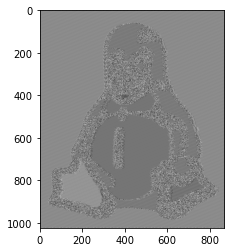

In [18]:
# Reshape the ciphertext into a matrix of bytes 
# Show the ciphertext
encrypted_tux = np.frombuffer(c, dtype = np.uint8).reshape(tux.shape)#reshape into the correct format

plt.imshow(encrypted_tux,cmap='gray')
plt.show()#main problem with ECB

## Example 4
We encrypt the Linux mascot with deterministic CTR, and see that patterns disappear.

In [19]:
# Generate a key and an instance of AES
k = urandom(KEYLEN)

In [20]:
# Generate the starting counter (in deterministic CTR, we start from 0)
iv = b'\x00'*BLOCKLEN#nonce, starts from zero(we want)

In [21]:
# Generate an instance of AES with the given key and nonce
cipher = Cipher(algorithms.AES(k), modes.CTR(iv))

In [22]:
# Encrypt the image
aes_encrypt = cipher.encryptor()
c = aes_encrypt.update(p) + aes_encrypt.finalize()

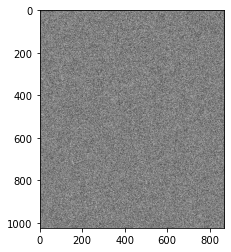

In [23]:
# Reshape the ciphertext into a matrix of bytes 
# Show the ciphertext
encrypted_tux = np.frombuffer(c, dtype = np.uint8).reshape(tux.shape)

plt.imshow(encrypted_tux,cmap='gray')
plt.show()#determ ctr mode is enough here

## Example 5
We generate a new ciphertext with the same key and still use deterministic CTR.
We then see that we can then learn about the plaintext 

In [24]:
# Load "The Black Cat" by Edgar Allan Poe 
# Uncomment the following line if you get an error of about a missing file
# !wget -q https://raw.githubusercontent.com/gverticale/network-security-and-cryptography/master/cat.txt

with open('cat.txt', 'rb') as myfile:#SAVE IV MULTIPLE TIMES
    cat=myfile.read()

# The file is shorter than the image, so we make it the same size
plaintext_cat = 50 * cat
plaintext_cat = plaintext_cat[0:len(p)]

In [25]:
# Encrypt the text with the same key and IV
cipher = Cipher(algorithms.AES(k), modes.CTR(iv))
aes_encrypt = cipher.encryptor()
encrypted_cat = aes_encrypt.update(plaintext_cat) + aes_encrypt.finalize()

In [26]:
# Reshape the encrypted poem into a matrix
encrypted_cat_rect = np.frombuffer(encrypted_cat, dtype = np.uint8).reshape(tux.shape)#REPEATED NOICE -> XOR BOTH ENCR FILES->
#->REMOVE THE KEY

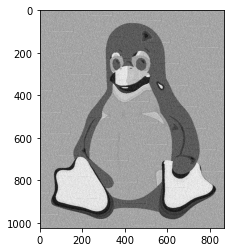

In [27]:
# Calculate the XOR between the ciphertexts
ciphertext_xor = np.bitwise_xor(encrypted_cat_rect, encrypted_tux)

plt.imshow(ciphertext_xor,cmap='gray')
plt.show()#all you knew is that the same key and the same IV was used(for determ ctr mode)

# Example 6

Let's use an authenticated cipher: AES-GCM

In [28]:
# Generate a key and an instance of AES-GCM
# The standard requires an 96-bit random IV

k = urandom(KEYLEN)
iv = urandom(12)#prevents overlapng
cipher = Cipher(algorithms.AES(k), modes.GCM(iv))

In [29]:
# Encrypt "The Black Cat" and authenticate the string "A poem"
gcm_encrypt = cipher.encryptor()
gcm_encrypt.authenticate_additional_data(b"A poem")
encrypted_cat = gcm_encrypt.update(plaintext_cat) + gcm_encrypt.finalize()
tag = gcm_encrypt.tag

In [30]:
# Now encrypt
cipher = Cipher(algorithms.AES(k), modes.GCM(iv,tag))#pass the tag too, it's for authentication

In [31]:
gcm_decrypt = cipher.decryptor()
gcm_decrypt.authenticate_additional_data(b"A new poem")
#gcm_decrypt.authenticate_additional_data(b"A poem")
try:#exeptions to manage the authentication
    decrypted_cat = gcm_decrypt.update(encrypted_cat) + gcm_decrypt.finalize()
    print(decrypted_cat)
except InvalidTag:
    print("Not authentic")
#try to repeat using randomized counter mode (random IVs)

Not authentic


# Lab Activity: Malleability of AES-CTR

1. Start from "THE BLACK CAT"
2. Encrypt it using AES-CTR (use a random IV)
3. Using ciphertext malleability change the ciphertext so that the title of the poem becomes "THE GREEN CAT"
4. Decrypt it showing the modified text
5. Repeat using AES-GCM and verify that it fails

_Quick note on the python library: the output of the encryption is immutable, you need to convert it to a list to modify it, then you need to convert it back to a bytes object_

In [32]:
#by changing the cypher change the msg: the title is the green cat 
#change the bythe at pos 10 -> change plaintext => when you decrypt you will get different
#xor(b,g) -> apply-> after xor b becomes g
#but then the authen will fail
#enctyption for the encr tag -> transform into a list(content) -> modify -> call bytes -> decrypt

In [33]:
with open('cat.txt', 'rb') as myfile:
    black_cat = myfile.read()

k = urandom(BLOCKLEN)
iv = urandom(BLOCKLEN)

cipher = Cipher(algorithms.AES(k), modes.CTR(iv))
aes_encrypt = cipher.encryptor()
encrypted_cat = aes_encrypt.update(black_cat) + aes_encrypt.finalize()

cat_in_bytes = bytes(list(encrypted_cat))#to modify
print(black_cat)

b'THE BLACK CAT\n\n                             by Edgar Allan Poe\n                                   (1843)\n\n   FOR the most wild, yet most homely narrative which I am about to pen, I\nneither expect nor solicit belief. Mad indeed would I be to expect it, in a\ncase where my very senses reject their own evidence. Yet, mad am I not --and\nvery surely do I not dream. But to-morrow I die, and to-day I would\nunburthen my soul. My immediate purpose is to place before the world,\nplainly, succinctly, and without comment, a series of mere household events.\nIn their consequences, these events have terrified --have tortured --have\ndestroyed me. Yet I will not attempt to expound them. To me, they have\npresented little but Horror --to many they will seem less terrible than\nbaroques. Hereafter, perhaps, some intellect may be found which will reduce\nmy phantasm to the common-place --some intellect more calm, more logical,\nand far less excitable than my own, which will perceive, in the\nc

In [34]:
black = b'BLACK'
green = b'GREEN'

In [35]:
def bitwise_xor_bytes(a, b):
    result_int = int.from_bytes(a, byteorder="big") ^ int.from_bytes(b, byteorder="big")
    return result_int.to_bytes(max(len(a), len(b)), byteorder="big")

In [36]:
b_xor_g = bitwise_xor_bytes(black, green)
d = b'\x00'*4+b_xor_g+b'\x00'*(len(black_cat)-9)

encrypted_cat_modified = bitwise_xor_bytes(cat_in_bytes, d)

In [37]:
aes_decrypt = cipher.decryptor()
green_cat = aes_decrypt.update(encrypted_cat_modified) + aes_decrypt.finalize()
print(green_cat)

b'THE GREEN CAT\n\n                             by Edgar Allan Poe\n                                   (1843)\n\n   FOR the most wild, yet most homely narrative which I am about to pen, I\nneither expect nor solicit belief. Mad indeed would I be to expect it, in a\ncase where my very senses reject their own evidence. Yet, mad am I not --and\nvery surely do I not dream. But to-morrow I die, and to-day I would\nunburthen my soul. My immediate purpose is to place before the world,\nplainly, succinctly, and without comment, a series of mere household events.\nIn their consequences, these events have terrified --have tortured --have\ndestroyed me. Yet I will not attempt to expound them. To me, they have\npresented little but Horror --to many they will seem less terrible than\nbaroques. Hereafter, perhaps, some intellect may be found which will reduce\nmy phantasm to the common-place --some intellect more calm, more logical,\nand far less excitable than my own, which will perceive, in the\nc

### Now lets try AES-GCM

In [38]:
with open('cat.txt', 'rb') as myfile:
    black_cat = myfile.read()

k = urandom(KEYLEN)
iv = urandom(12)#prevents overlapng
cipher = Cipher(algorithms.AES(k), modes.GCM(iv))

In [39]:
# Encrypt "The Black Cat" and authenticate the string "A poem"
gcm_encrypt = cipher.encryptor()
gcm_encrypt.authenticate_additional_data(b"Tell the truth")
encrypted_cat = gcm_encrypt.update(black_cat) + gcm_encrypt.finalize()
tag = gcm_encrypt.tag

cat_in_bytes = bytes(list(encrypted_cat))#to modify

In [40]:
cipher = Cipher(algorithms.AES(k), modes.GCM(iv,tag))

In [41]:
black = b'BLACK'
green = b'GREEN'

In [42]:
b_xor_g = bitwise_xor_bytes(black, green)

d = b'\x00'*4+b_xor_g+b'\x00'*(len(black_cat)-9)
encrypted_cat_modified =bitwise_xor_bytes(cat_in_bytes, d)

In [43]:
gcm_decrypt = cipher.decryptor()
gcm_decrypt.authenticate_additional_data(b"Tell the truth")
#gcm_decrypt.authenticate_additional_data(b"Lies")
try:#exeptions to manage the authentication
    green_cat = gcm_decrypt.update(encrypted_cat_modified) + gcm_decrypt.finalize()
    print(green_cat)
    #black_cat_dec = gcm_decrypt.update(encrypted_cat) + gcm_decrypt.finalize()
    #print(black_cat_dec)
except InvalidTag:
    print("Not authentic")

Not authentic


# Lab Activity: Randomized CTR

1. Wncrypt tux with randomized CTR
2. Encrypt cat with randomized CTR
3. Compute bitwise xor of the ciphertexts
4. Show the result

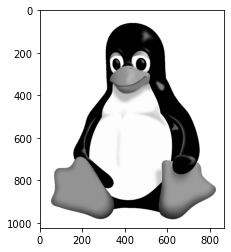

In [44]:
tux = plt.imread('tux_gray.png')
plt.imshow(tux)
plt.show()

In [45]:
# Keep only luminance and serialize the image
# The plaintext is a string of bytes
tux = tux[:,:,1] * 255
tux = tux.astype(np.uint8)
p = tux.tobytes()

In [46]:
# Generate a key and an instance of AES
k = urandom(KEYLEN)

In [47]:
iv1 = urandom(BLOCKLEN)
cipher = Cipher(algorithms.AES(k), modes.CTR(iv1))

In [48]:
# Encrypt the image
aes_encrypt = cipher.encryptor()
c = aes_encrypt.update(p) + aes_encrypt.finalize()

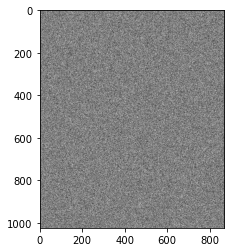

In [49]:
# Reshape the ciphertext into a matrix of bytes 
# Show the ciphertext
encrypted_tux = np.frombuffer(c, dtype = np.uint8).reshape(tux.shape)

plt.imshow(encrypted_tux,cmap='gray')
plt.show()

In [50]:
with open('cat.txt', 'rb') as myfile:#SAVE IV MULTIPLE TIMES
    cat=myfile.read()

# The file is shorter than the image, so we make it the same size
plaintext_cat = 50 * cat
plaintext_cat = plaintext_cat[0:len(p)]

In [51]:
# Encrypt the text with the different IV
iv2 = urandom(BLOCKLEN)
cipher = Cipher(algorithms.AES(k), modes.CTR(iv2))
aes_encrypt = cipher.encryptor()
encrypted_cat = aes_encrypt.update(plaintext_cat) + aes_encrypt.finalize()

In [52]:
# Reshape the encrypted poem into a matrix
encrypted_cat_rect = np.frombuffer(encrypted_cat, dtype = np.uint8).reshape(tux.shape)

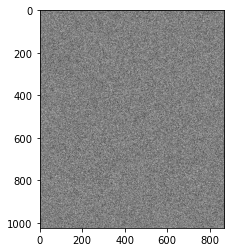

In [53]:
# Calculate the XOR between the ciphertexts
ciphertext_xor = np.bitwise_xor(encrypted_cat_rect, encrypted_tux)

plt.imshow(ciphertext_xor,cmap='gray')
plt.show()